In [2]:
import random
import torch
import torch.nn.functional as F

N = 4096
N_pad = 8
Head = 32
SeqLen = 6

wq = torch.load("/home/lkh/Projects/ML/llama/layers_15_attention_wq_weight.pth").cpu().float()
wk = torch.load("/home/lkh/Projects/ML/llama/layers_15_attention_wk_weight.pth").cpu().float()
x = torch.load("/home/lkh/Projects/ML/llama/x.pth").cpu().float()[0]

def QK(x, wq, wk):
    xq = x @ wq
    xk = x @ wk
    xq = xq.view(SeqLen, Head, -1)
    xk = xk.view(SeqLen, Head, -1)
    xq = xq.transpose(0, 1)
    xk = xk.transpose(0, 1)
    qk = xq @ xk.transpose(1, 2)
    return qk

qk = QK(x, wq, wk)

s = F.softmax(qk, -1)

In [3]:
# // ------------------------------------ //
# // pad and shuffle
# // ----------------------------------- //


def add_pad(t: torch.Tensor):
    pad = 0.0238 * torch.randn(t.size()[0], N_pad)
    t = torch.cat((t, pad), 1)
    return t, pad


def shuffle_col(tensor: torch.Tensor):
    for _ in range(int(1)):
        a = random.randint(0, tensor.size()[-1] - 1)
        b = random.randint(0, tensor.size()[-1] - 1)
        if a == b:
            b = (a + 1) % tensor.size()[-1]
        tensor[:, [a, b]] = tensor[:, [b, a]]


def mask(wq: torch.Tensor, wk: torch.Tensor):
    def pad(w):
        w1 = w.view(N, Head, -1)
        param_dim, head_num, head_dim = w1.shape
        w2 = torch.zeros((param_dim, head_num, head_dim + N_pad))
        pad = torch.zeros_like(w2)
        for i, it in enumerate(w1):
            w2[i, :], pad[i, :, head_dim:] = add_pad(it)
        return w2, pad

    def shuffle(w: torch.Tensor):
        w = w.transpose(0, 1)
        for it in w:
            shuffle_col(it)
        w = w.transpose(0, 1)

    def shape(v):
        return v.reshape((N, -1))

    wq_, pad_q = pad(wq)
    wk_, pad_k = pad(wk)
    union = torch.cat((wq_, wk_, pad_q, pad_k), 0)
    shuffle(union)
    wq_, wk_, pad_q, pad_k = torch.split(union, split_size_or_sections=N, dim=0)
    return shape(wq_), shape(wk_), shape(pad_q), shape(pad_k)


wq_, wk_, pad_q, pad_k = mask(wq, wk)
qk_ = QK(x, wq_, wk_)
pad = QK(x, pad_q, pad_k)
s_ = F.softmax(qk_, -1)
s__ = F.softmax(qk_ - pad, -1)
print(f"qk_ - pad == qk is {torch.allclose(qk_ - pad, qk, 10e-4)}")


qk_ - pad == qk is True


In [24]:
# // ------------------------------------ //
# // analysis
# // ----------------------------------- //

from matplotlib import pyplot as plt
from numpy import argmax


def histogram(tensor_example, lhs=None, rhs=None):
    if lhs == None:
        lhs = tensor_example.min()
    if rhs == None:
        rhs = tensor_example.max()
    # lhs, rhs = -0.1, 0.2
    histogram = torch.histc(tensor_example, bins=1000, min=lhs, max=rhs)
    bin_edges = torch.linspace(lhs, rhs, steps=len(histogram) + 1)
    # 可视化直方图
    plt.bar(bin_edges[:-1], histogram, width=(bin_edges[1] - bin_edges[0]))
    plt.title("Histogram of Tensor Data")
    plt.yscale('log')  # 设置纵坐标为对数坐标轴
    plt.show()

def func_analysis(v, v_, name):
    print(f"{name}'s norm-2 is {v.norm(2)}")
    print(f"{name}_'s norm-2 is {v_.norm(2)}")
    print(f"({name}-{name}_)'s norm-2 div {name}'s norm-2  is {(v-v_).norm(2) / v.norm(2)}")

func_analysis(qk, qk_, "qk")
func_analysis(s, s_, "s")


qk's norm-2 is 129.9247283935547
qk_'s norm-2 is 133.7620849609375
(qk-qk_)'s norm-2 div qk's norm-2  is 0.20975962281227112
s's norm-2 is 11.039290428161621
s_'s norm-2 is 11.134868621826172
(s-s_)'s norm-2 div s's norm-2  is 0.24192997813224792


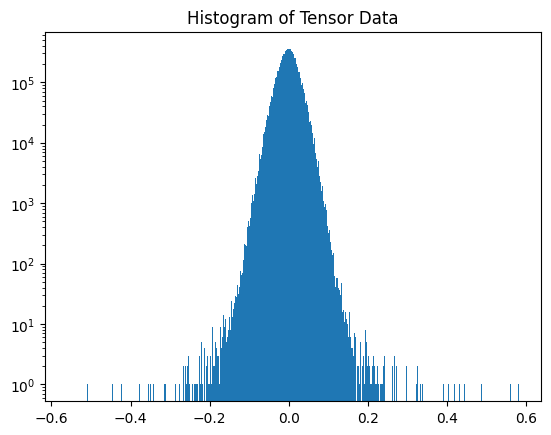

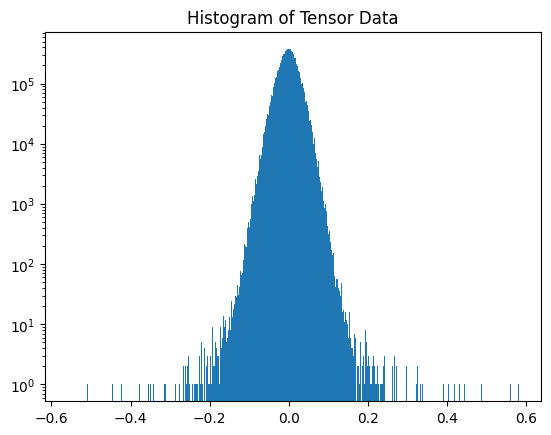

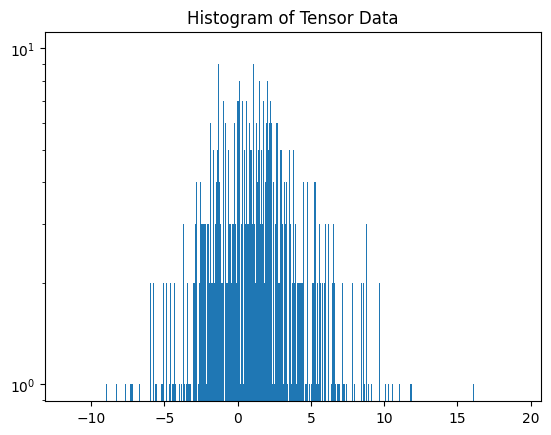

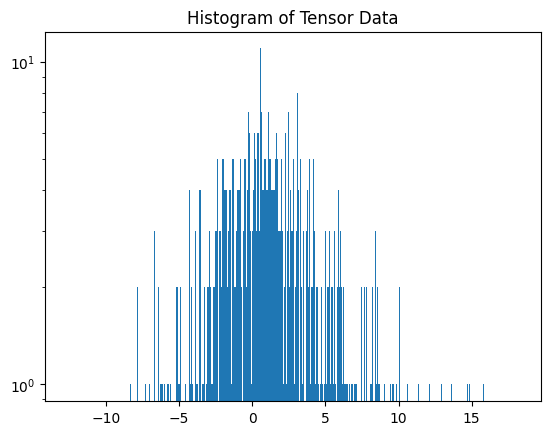

In [26]:
lr = (None, None)
histogram(wq, *lr)
histogram(wq_, *lr)
histogram(qk)
histogram(qk_)

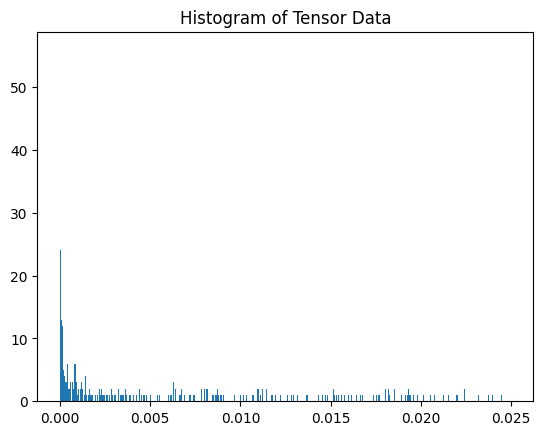

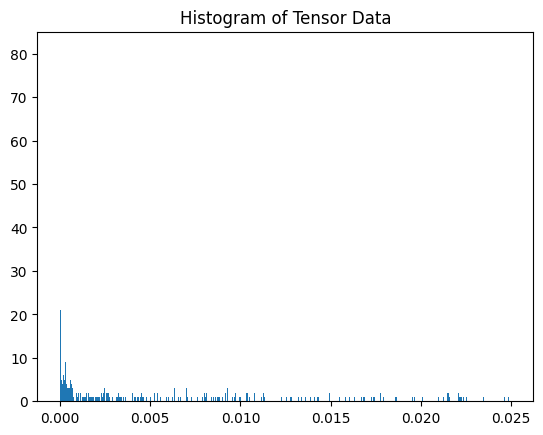

In [6]:
lr_s = (0, 0.025)
histogram(s, *lr_s)
histogram(s_, *lr_s)